# Prepare data


In [32]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('shakespeare.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 1115394


To make inputs out of this big string of data, we will be splitting it into chunks.

In [33]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

rcumvention? 'Tis not four days gone
Since I heard thence; these are the words: I think
I have the letter here; yes, here it is.
'They have press'd a power, but it is not known
Whether for east or west


# Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [34]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

# Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [35]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [36]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [37]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

# Training

A helper to print the amount of time passed:

In [38]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [39]:
# def train(inp, target):
#     hidden = decoder.init_hidden()
#     decoder.zero_grad()
#     loss = 0

#     for c in range(chunk_len):
#         output, hidden = decoder(inp[c], hidden)
#         loss += criterion(output, target[c])

#     loss.backward()
#     decoder_optimizer.step()

#     return loss.data[0] / chunk_len

def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

 13s (100 5%) 2.1292]
Whind that me mwint.
Yousg!
Hof aw to dis feavk and warim thine thint wan wonds, thind ad
Neat thite c 

 25s (200 10%) 2.2271]
Wheper's am in the darst what stir:
And the the thhar to the,
Hally Voodf thour to with chave for hist 

 37s (300 15%) 2.1396]
Wheme the the maw stave a me bake aly vell!
The say, say sattath liet,
Whor pise peard thoother that a 

 49s (400 20%) 2.0825]
Whar Lrie nothe to well off you, he are anod the ay.

DUKENENTIO:
He kinder to do is goostuse sewer wn 

 1s (500 25%) 1.7780]
Whers
And will you ther and pear to now the gurpan, that lak'd ceco in are you siciught.

PRESTROS:
Mi 

 13s (600 30%) 1.7143]
Why for bove made hith come mane thear the seamoul:
Then the fier more the have their not deesty'
And  

 25s (700 35%) 1.8169]
Wheren a wiclaren'd ame larsse, I apapiven all, for actain thou did
So rove me mast Cull tent I him, t 

 38s (800 40%) 1.7999]
Why charders in my may priest ine bus
Thou bes to to the decomman abding in to cruc

<Figure size 640x480 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Perplexity')

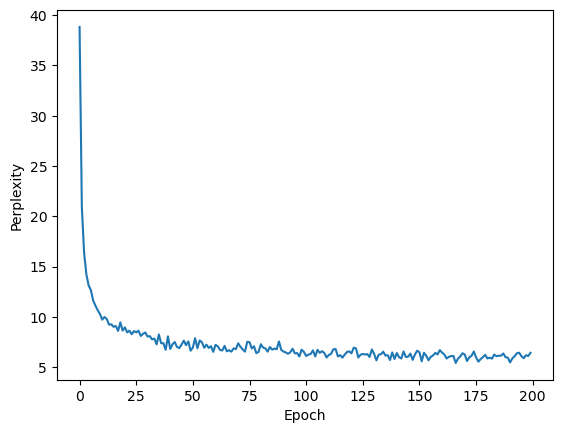

In [40]:
import math
import matplotlib.pyplot as plt

n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
perplexities = []   # added line
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        perplexity = math.exp(loss_avg / plot_every)   # calculate perplexity
        perplexities.append(perplexity)                # add perplexity to list
        loss_avg = 0

plt.figure()
plt.plot(perplexities)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.show()


# Task 2



In [50]:

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.figsize': (200.0, 10.0)}


# set the model to evaluation mode
decoder.eval()

# generate and print 3 sequences
for i in range(3):
    prime_str = ''.join(random.choices(all_characters, k=5))
    generated = evaluate(prime_str, predict_len=100)
    print("Prime: ", prime_str)
    print("Generated: " , generated)
    print(" ------ ")


RNN(
  (encoder): Embedding(100, 100)
  (gru): GRU(100, 100)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

Prime:  t-0k=
Generated:  t-0k=e
To OF ANNENIUS:
Will that what the, weet are when undelath.

GLOUCESTER:
While was to thy with tre
 ------ 
Prime:  5|9l1
Generated:  5|9l1ess with their with plassus must,
Romether see revecourth while not with foold but whispell fols;
Wh
 ------ 
Prime:  RD9X%
Generated:  RD9X%:
Hand with the blowe, with theing in'ts valle throse
Sake my with to Romeoth with dook elde the tim
 ------ 


# Task 3


In [51]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%config InlineBackend.figure_format = 'svg'
%config InlineBackend.rc = {'figure.figsize': (200.0, 10.0)}


# Set the model to evaluation mode
decoder.eval()

# Generate sequences for each priming sequence
for prime_str in ['The', 'What is', 'Shall I give', 'X087hNYB BHN BYFVuhsdbs']:
    generated = evaluate(prime_str, predict_len=100)
    print("Prime: ", prime_str)
    print("Generated: " , generated)
    print(" ------ ")


RNN(
  (encoder): Embedding(100, 100)
  (gru): GRU(100, 100)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
)

Prime:  The
Generated:  The of where.

Lord Andich:
When's in natigaritienger ose soremis mine
Of Anguiet, ate a was who gompat
 ------ 
Prime:  What is
Generated:  What is musting thoo so,
You to the elple nires with that will over phost clive
We wad a mast duson of my m
 ------ 
Prime:  Shall I give
Generated:  Shall I give to that
Drid hath-up to math in mut tilet indom Nord,
Let to to to sungle, not my with;
I vils one 
 ------ 
Prime:  X087hNYB BHN BYFVuhsdbs
Generated:  X087hNYB BHN BYFVuhsdbs:
Oes: he not with the with of York come well wheren.

GLORES:
I was prespible tended?
Her powary st
 ------ 


#Plotting the Training Losses


<Figure size 640x480 with 0 Axes>

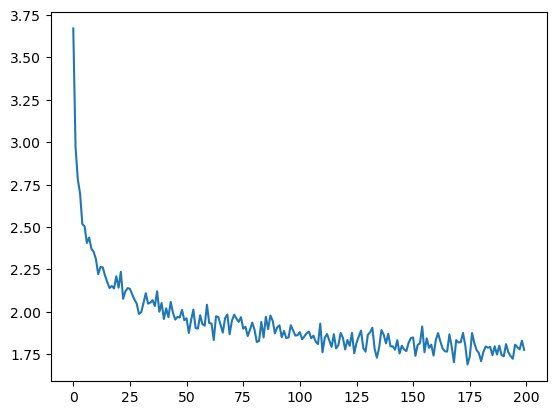

In [31]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)